# Models_comparison

If you arrived here, it means that you are really interested in the forecasting models, but unfortunately I will not explain it in detail, so I will leave some interesting links below that helped me a lot in creating them. 

https://medium.com/datadriveninvestor/warm-up-in-regression-analysis-ed330cf08a6e

https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

https://towardsdatascience.com/how-to-reshape-data-and-do-regression-for-time-series-using-lstm-133dad96cd00

https://towardsdatascience.com/regression-an-explanation-of-regression-metrics-and-what-can-go-wrong-a39a9793d914#:~:text=Root%20Mean%20Squared%20Error%3A%20RMSE,value%20predicted%20by%20the%20model.&text=Mean%20Absolute%20Error%3A%20MAE%20is,value%20predicted%20by%20the%20model.

At the request of the advanced data science capstone course, the version of each model was created with and without PCA, so to facilitate the creation of the same and not waste a lot of time with it, I used a pipeline on all scikitlearn lib models.


Due to the objective of the model to fully hit the closing value of the stock, I chose to use the r² and the rmse. Where the r² is the coefficient of determination and it's proportion of the variance in the dependent variable, so the closer to 1 more is the forecast get closer of the real value. The RMSE is the root mean squared error, thus it's get the difference between the real value and the predict value of whole test set.

The train_test_split used is 0.8 and 0.2.



In [1]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.patches as mpatches
import datetime
import h5py
from joblib import dump, load

In [2]:
df_completed = pd.read_csv("Data//Normalized_data.csv",sep=";",index_col=0)
df_completed = df_completed.sort_index(ascending = False).reset_index(drop=True)
df_completed.tail()

,Date,Close,Open,High,Low,Vol,Var,Open_Dollar,Open_IBOVESPA,DayofWeek,Weekofyear,Quarter,Month,News_N,News_NN,News_P
3742,2020-05-14,22.55,0.820163,0.943238,0.783646,1.884916,1.908617,3.894482,0.986630,3,20,2,5,0,0,1
3743,2020-05-15,21.63,0.964747,0.964887,0.894297,0.826410,-1.826023,3.761788,1.054690,4,20,2,5,0,0,1
3744,2020-05-18,22.67,0.958672,0.985333,0.941016,1.345042,2.089184,3.814842,0.975941,0,21,2,5,0,0,1
3745,2020-05-19,21.69,0.980542,0.958873,0.891838,0.948988,-1.931720,3.654746,1.174667,1,21,2,5,0,0,1
3746,2020-05-20,21.60,0.895492,0.866266,0.861102,0.983504,-0.209734,3.697540,1.149977,2,21,2,5,0,0,1


In [3]:
X = df_completed[['Open','Open_Dollar','Open_IBOVESPA','News_N','News_NN','News_P']]
y = df_completed['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)

In [4]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((2997, 6), (750, 6), (2997,), (750,))

In [5]:
range_df = df_completed.Date
df=pd.DataFrame(index = df_completed.Date)

In [6]:
regr = LinearRegression()
pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

In [7]:
dump(pipe, 'Models//Linear_reg_model.joblib')

['Models//Linear_reg_model.joblib']

In [8]:
y_test.shape, ypipe.shape

((750,), (750,))

In [9]:
y_train = y_train.reset_index()
del y_train['index']
y_trainValue = y_train['Close'].values
y_test = y_test.reset_index()
del y_test['index']
y_testValue = y_test['Close'].values

In [10]:
predictions_series = pd.Series(ypipe, index=df.index[X_train.shape[0]:])
train_series = pd.Series(y_trainValue, index=df.index[:X_train.shape[0]])
test_series = pd.Series(y_testValue, index=df.index[X_train.shape[0]:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

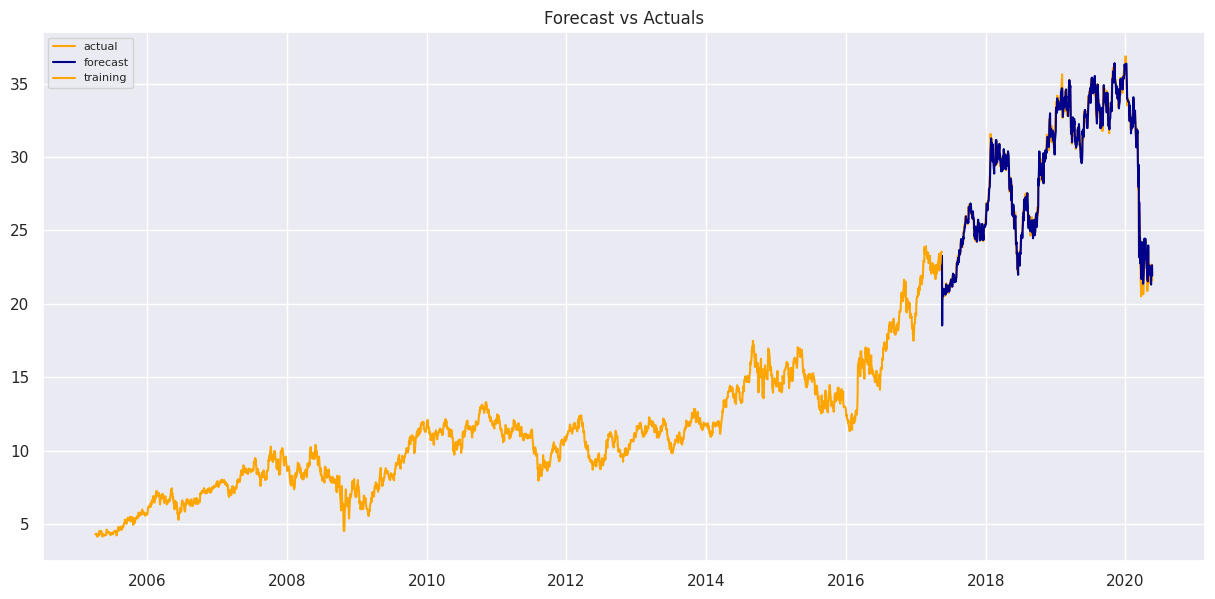

In [11]:
plt.figure(figsize=(15,7), dpi=100)
plt.plot(test_series, label='actual',color = 'orange')
plt.plot(predictions_series, label='forecast',color='darkblue')
plt.plot(train_series, label='training', color='orange' )
#plt.fill_between(train_labels.index, train_labels, test_labels, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

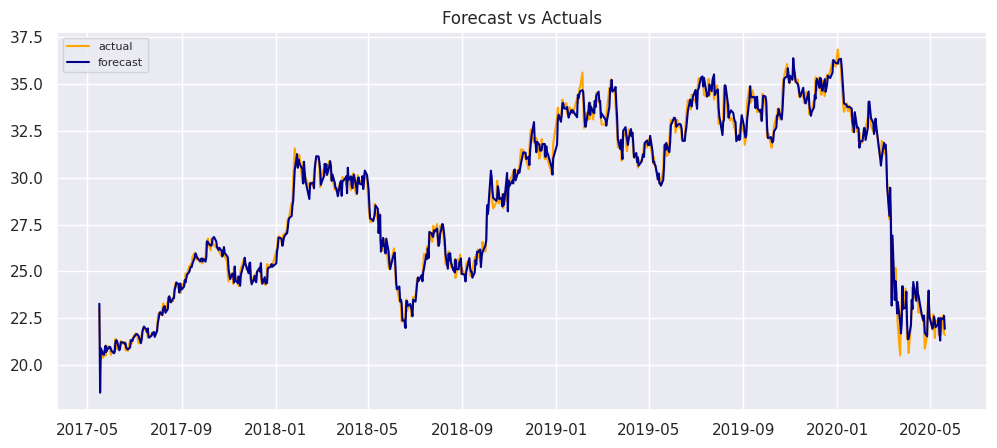

In [12]:
plt.figure(figsize=(12,5), dpi=100)
#plt.plot(train_labels, label='training')
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'darkblue')
#plt.fill_between(train_labels.index, train_labels, test_labels, 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
def forecast_accuracy(predictions, test_labels):
    forecast = predictions
    actual = test_labels
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    r_squared = corr**2

    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr,'r_squared':r_squared,
            'minmax':minmax,
           })

Linear_model_perf = forecast_accuracy(predictions_series, test_series)
Linear_model_perf

{'mape': 0.012696498933185073,
 'me': 0.011759392572044244,
 'mae': 0.362663140188169,
 'mpe': 0.0005871915095851897,
 'rmse': 0.4731329502971302,
 'corr': 0.9944502842364518,
 'r_squared': 0.9889313678179597,
 'minmax': 0.012549791038413471}

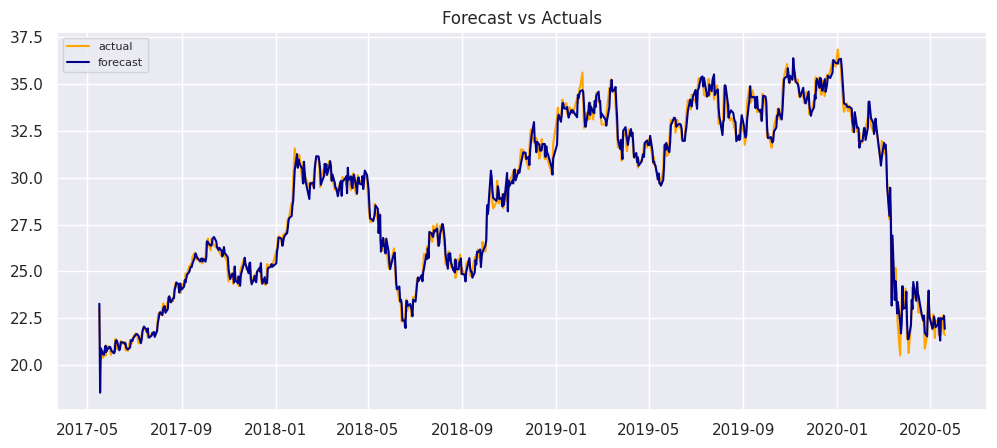

In [14]:
## Linear Reg wout/ PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)
regr = LinearRegression()
pipe = Pipeline([
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)
predictions_series = pd.Series(ypipe, index=df.index[int(X_train.shape[0]):])
train_series = pd.Series(y_trainValue, index=df.index[:X_train.shape[0]])
test_series = pd.Series(y_testValue, index=df.index[X_train.shape[0]:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'darkblue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
Linear_model_perf = forecast_accuracy(predictions_series, test_series)

## Ridge Regression

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)
df=pd.DataFrame(index = df_completed.Date)

In [17]:
regr = Ridge()
pipe = Pipeline([
        ('reduce_dim', PCA()),
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)

In [18]:
dump(pipe, 'Models//Ridge_reg_model.joblib')

['Models//Ridge_reg_model.joblib']

In [19]:
predictions_series = pd.Series(ypipe, index=df.index[int(X_train.shape[0]):])
train_series = pd.Series(y_trainValue, index=df.index[:X_train.shape[0]])
test_series = pd.Series(y_testValue, index=df.index[X_train.shape[0]:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)

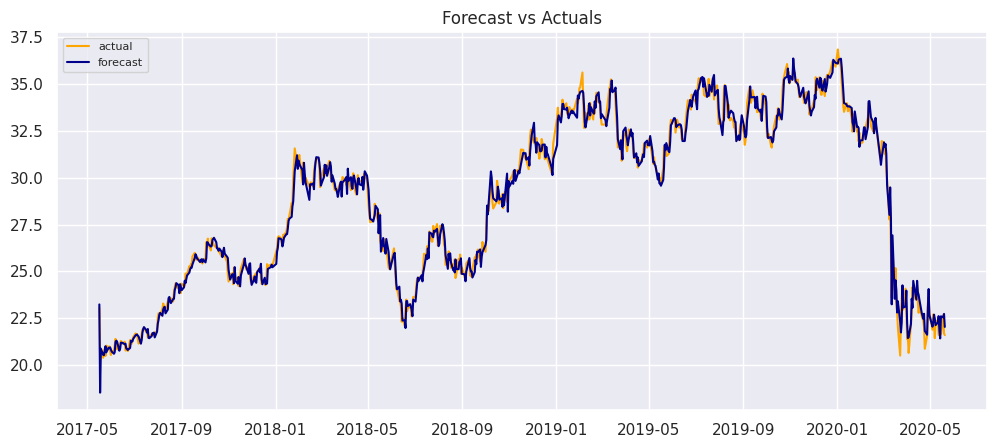

In [20]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'darkblue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
Ridge_model_perf = forecast_accuracy(predictions_series, test_series)

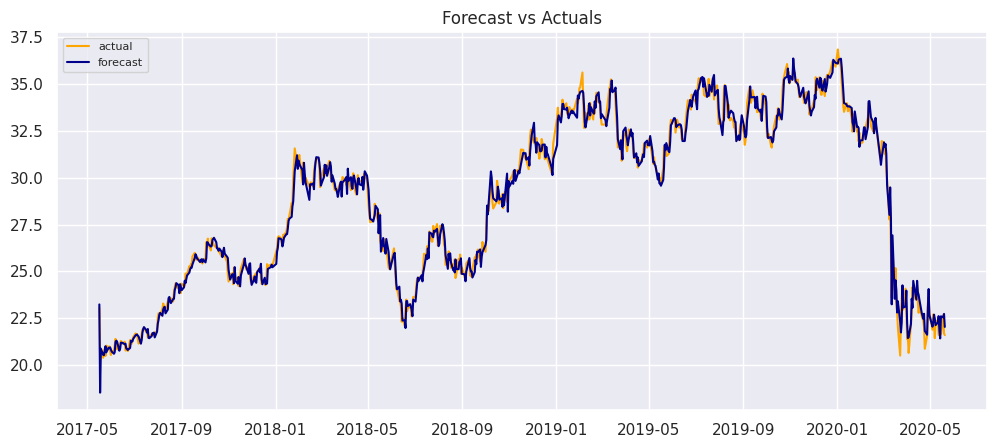

In [22]:
## Ridge wout/ PCA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)
regr = Ridge()
pipe = Pipeline([
        ('regressor', regr)
        ])
pipe.fit(X_train,y_train)
ypipe=pipe.predict(X_test)
predictions_series = pd.Series(ypipe, index=df.index[int(X_train.shape[0]):])
train_series = pd.Series(y_trainValue, index=df.index[:X_train.shape[0]])
test_series = pd.Series(y_testValue, index=df.index[X_train.shape[0]:])
## Convert index to datetime
predictions_series.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
test_series.index = pd.to_datetime(test_series.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'darkblue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [23]:
forecast_accuracy(predictions_series, test_series)

{'mape': 0.012768924646897705,
 'me': 0.002553247361063626,
 'mae': 0.36439573721563334,
 'mpe': 0.0002974842427054297,
 'rmse': 0.4753148321559142,
 'corr': 0.9943909384685378,
 'r_squared': 0.9888133385083393,
 'minmax': 0.012620569783930002}

## Statistical models

In the previous step, Data_analysis, we could got that this time series has trends and seasonality, and the most important it isn't non-stationary. I'm using a powerful lib called pmdarima with has auto_arima, what is that? it will iterate our data and pick the best combination about (p,q,i) and the ARIMA, Sarima, MA or AR (that has the smallest AIC). knowing that the exogenous variables have a high correlation, it's a little bit obvious that will pick a ARIMAX or SARIMAX, this also applies to seasonality. So it has a high probability to get a SARIMAX with the smallest AIC.

In [24]:
## Preparing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)

In [25]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(y_train, 
                     exogenous= X_train,
                     start_p=1, start_q=1, 
                     max_p=7, max_q=7, 
                     d=1, max_d=7,
                     trace=True, 
                     error_action='ignore', 
                     suppress_warnings=True, 
                     stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-1066.390, BIC=-1006.339, Time=13.246 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-467.628, BIC=-419.588, Time=1.298 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-665.874, BIC=-611.829, Time=9.018 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-1087.669, BIC=-1033.623, Time=20.389 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-468.227, BIC=-426.192, Time=5.794 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=-1072.961, BIC=-1012.910, Time=18.307 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=-1059.271, BIC=-993.216, Time=18.579 seconds
Total fit time: 86.641 seconds


In [26]:
step_wise.summary()

/home/anthony/Capstone Advanced DS/github/Analytics/venv/lib/python3.7/site-packages/statsmodels/base/model.py:1354: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/home/anthony/Capstone Advanced DS/github/Analytics/venv/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/anthony/Capstone Advanced DS/github/Analytics/venv/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2885: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2997
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 552.834
Date:                Mon, 29 Jun 2020   AIC                          -1087.669
Time:                        23:00:15   BIC                          -1033.623
Sample:                             0   HQIC                         -1068.227
                               - 2997                                         
Covariance Type:                  opg                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0003      0.000      2.255      0.024    3.37e-05       0.000
Open              7.9261      0.076    104.812      0.000       7.778       8.074
Open_Dollar      -0.0919      0.033     -2.784      0.005      -0.157      -0.027
Open_IBOVESPA    -0.0150      0.027     -0.551      0.582      -0.068       0.038
News_N                 0        nan        nan        nan         nan         nan
News_NN                0         -0        nan        nan           0           0
News_P        -6.968e-10   2.36e-12   -295.220      0.000   -7.01e-10   -6.92e-10
ma.L1            -0.9748      0.008   -117.259      0.000      -0.991      -0.958
sigma2            0.0404      0.001     54.931      0.000       0.039       0.042
===================================================================================
Ljung-Box (Q):                       26.36   Jarque-Bera (JB):               558.70
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.18e+37. Standard errors may be unstable.
"""

The best statistical forecast model was the SARIMAX(0,1,1), let's apply it.

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(y_train, 
 exog=X_train,
 order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)

In [28]:
results= model.fit()

In [29]:
dump(model, 'Models//SARIMAX_Reg_model.joblib') 

['Models//SARIMAX_Reg_model.joblib']

In [30]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2997, 6), (750, 6), (2997,), (750,))

In [31]:
steps=-1
train_size = X_train.shape[0]
test_size = y_test.shape[0]
predictions= results.predict(start =train_size, end=train_size+test_size+(steps),exog=X_test)

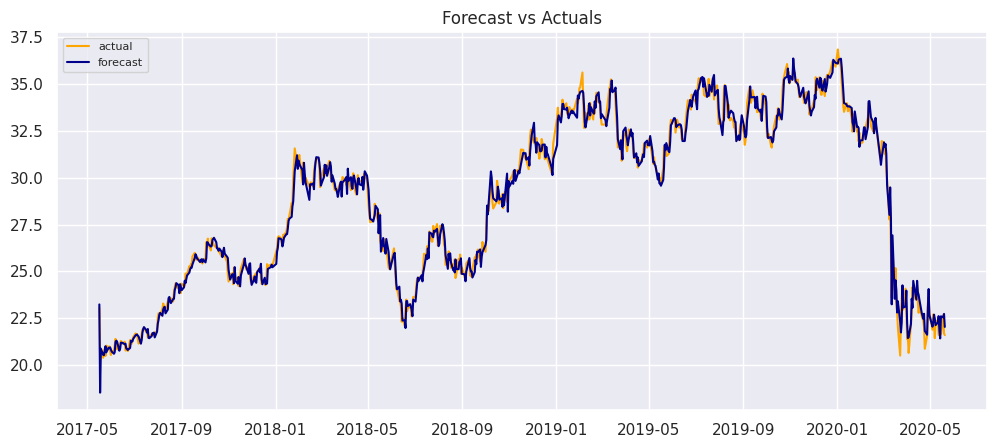

In [32]:
predictions.index = pd.to_datetime(predictions_series.index)
train_series.index = pd.to_datetime(train_series.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_series, label='actual',color ='orange')
plt.plot(predictions_series, label='forecast', color = 'darkblue')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
SARIMAX_Model_perf = forecast_accuracy(predictions, test_series)
SARIMAX_Model_perf

{'mape': 0.014228505295229532,
 'me': -0.2359904694566313,
 'mae': 0.4139366185165785,
 'mpe': -0.007420712358535968,
 'rmse': 0.5405665003370218,
 'corr': 0.9944679163621591,
 'r_squared': 0.9889664366736943,
 'minmax': 0.014157413831953236}

# LSTM Regressor model

As the requeriment of the project have a Deep learning model, it was chosen the most famous for regressions. The model is using Keras lib that is a very simplest way to create deep learning model using TensorFlow in backend, there's some disadvantages compared to pytorch, but to gain some velocity I opted for it.  

The model has not been tuned, so I basically picked a LSTM model in the IBM course and ajusted it to my data, calculing the batch_size and time_steps for my time serie, the hyperparameter stateful was chose, due the sequences related as we saw with ACF in the previous step that represented a high interconnection 

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=0, shuffle=False)

In [35]:
batch_size = 64
epochs = 120
timesteps = 10

def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = len(dataset)
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print(x)
    return (max(train_length_values))

In [36]:
df_completed.head()

,Date,Close,Open,High,Low,Vol,Var,Open_Dollar,Open_IBOVESPA,DayofWeek,Weekofyear,Quarter,Month,News_N,News_NN,News_P
0,2005-04-05,4.32,-1.245328,-1.245674,-1.237570,2.284068,-0.029168,0.058483,-1.832276,1,14,2,4,0,0,1
1,2005-04-06,4.31,-1.244113,-1.249282,-1.237570,2.174766,-0.130461,0.049738,-1.852550,2,14,2,4,0,0,1
2,2005-04-07,4.33,-1.245328,-1.252890,-1.237570,2.176978,0.173419,0.010443,-1.871371,3,14,2,4,0,0,1
3,2005-04-08,4.30,-1.244113,-1.254093,-1.238799,0.611345,-0.333048,0.010676,-1.837899,4,14,2,4,0,0,1
4,2005-04-11,4.34,-1.245328,-1.250485,-1.237570,0.175021,0.380410,0.000182,-1.861018,0,15,2,4,0,0,1


In [37]:
y = df_completed.iloc[:,1:2].values.astype(float)  
length = get_train_length(y, batch_size, 0.2)
print(length)

2944
2944


In [38]:
#Adding timesteps * 2
upper_train = length + timesteps*2
df_data_1_train = pd.DataFrame(y[0:upper_train])
training_set = df_data_1_train.values
training_set.shape

(2964, 1)

In [39]:
# Feature Scaling
#scale between 0 and 1. the weights are esier to find.
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(np.float64(training_set))
training_set_scaled.shape

(2964, 1)

In [40]:
### Creating Lags 

length = len(training_set_scaled)
timesteps = 5

X_train = []
y_train = []

# Creating a data structure with n timesteps
for i in range(timesteps, length + timesteps): 
    
    X_train.append(training_set_scaled[i-timesteps:i,0])
    y_train.append(training_set_scaled[i:i+timesteps,0])

print(len(X_train))
print(len(y_train))
print(X_train[0:2])
print(np.array(X_train).shape)
print(y_train[0:2])
print(np.array(y_train).shape)

2964
2964
[array([0.0091001 , 0.00859454, 0.00960566, 0.00808898, 0.01011122]), array([0.00859454, 0.00960566, 0.00808898, 0.01011122, 0.00859454])]
(2964,)
[array([0.00859454, 0.00859454, 0.00353893, 0.        , 0.00252781]), array([0.00859454, 0.00353893, 0.        , 0.00252781, 0.00758342])]
(2964,)


/home/anthony/Capstone Advanced DS/github/Analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/anthony/Capstone Advanced DS/github/Analytics/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [41]:
X_train = np.vstack(X_train[:2944])
y_train = np.vstack(y_train[:2944])

In [42]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [43]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(2944, 5, 1)
(2944, 5, 1)


In [44]:
# Building the LSTM
# Importing the Keras libraries and packages
from keras.layers import Dense
from keras.layers import Input, LSTM
from keras.models import Model

Using TensorFlow backend.


In [45]:
# Initialising the LSTM Model with MAE Loss-Function
# Using Functional API

inputs_1_mae = Input(batch_shape=(batch_size,timesteps,1))
#each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)

output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

#adam is fast starting off and then gets slower and more precise
#mae -> mean absolute error loss function
regressor_mae.compile(optimizer='adam', loss = 'mae')   ### mae
regressor_mae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (64, 5, 1)                0         
_________________________________________________________________
lstm_1 (LSTM)                (64, 5, 10)               480       
_________________________________________________________________
lstm_2 (LSTM)                (64, 5, 10)               840       
_________________________________________________________________
dense_1 (Dense)              (64, 5, 1)                11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [46]:
#Statefull
for i in range(epochs):
    print("Epoch: " + str(i))
    #run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(X_train, y_train, shuffle=False, epochs = 1, batch_size = batch_size)
    #resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()

Epoch: 0
Epoch 1/1
2944/2944 [==============================] - 1s 290us/step - loss: 0.0866
Epoch: 1
Epoch 1/1
2944/2944 [==============================] - 0s 84us/step - loss: 0.0892
Epoch: 2
Epoch 1/1
2944/2944 [==============================] - 0s 85us/step - loss: 0.0678
Epoch: 3
Epoch 1/1
2944/2944 [==============================] - 0s 70us/step - loss: 0.0689
Epoch: 4
Epoch 1/1
2944/2944 [==============================] - 0s 84us/step - loss: 0.0662
Epoch: 5
Epoch 1/1
2944/2944 [==============================] - 0s 86us/step - loss: 0.0722
Epoch: 6
Epoch 1/1
2944/2944 [==============================] - 0s 80us/step - loss: 0.0665
Epoch: 7
Epoch 1/1
2944/2944 [==============================] - 0s 82us/step - loss: 0.0696
Epoch: 8
Epoch 1/1
2944/2944 [==============================] - 0s 79us/step - loss: 0.0648
Epoch: 9
Epoch 1/1
2944/2944 [==============================] - 0s 100us/step - loss: 0.0620
Epoch: 10
Epoch 1/1
2944/2944 [==============================] - 0s 77us/step 

In [47]:
regressor_mae.save(filepath="Models//LSTM_reg_model.h5")

In [48]:
def get_test_length(dataset, batch_size):
    
    test_length_values = []
    for x in range(len(dataset) - 200, len(dataset) - timesteps*2): 
        modulo=(x-upper_train)%batch_size
        if (modulo == 0):
            test_length_values.append(x)
            print(x)
    return (max(test_length_values))

In [49]:
test_length = get_test_length(y, batch_size)
print(test_length)
upper_test = test_length + timesteps*2
testset_length = test_length - upper_train
print(testset_length)

3604
3668
3732
3732
768


In [50]:
print(upper_train, upper_test, len(y))

2964 3742 3747


In [51]:
# construct test set

#subsetting
df_data_1_test = y[upper_train:upper_test] 
test_set = df_data_1_test #df_data_1_test.iloc[:,1:2].values

#scaling
scaled_real_bcg_values_test = sc.fit_transform(np.float64(test_set))

#creating input data
X_test = []
for i in range(timesteps, testset_length + timesteps):
    X_test.append(scaled_real_bcg_values_test[i-timesteps:i, 0])
X_test = np.array(X_test)


#reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [52]:
y_test.shape

(750,)

In [53]:
#prediction
predicted_bcg_values_test_mae = regressor_mae.predict(X_test, batch_size=batch_size)
regressor_mae.reset_states()

print(predicted_bcg_values_test_mae.shape)

#reshaping
predicted_bcg_values_test_mae = np.reshape(predicted_bcg_values_test_mae, 
                                       (predicted_bcg_values_test_mae.shape[0], 
                                        predicted_bcg_values_test_mae.shape[1]))

print(predicted_bcg_values_test_mae.shape)
#inverse transform
predicted_bcg_values_test_mae = sc.inverse_transform(predicted_bcg_values_test_mae)


#creating y_test data
y_test = []
for j in range(0, testset_length - timesteps):
    y_test = np.append(y_test, predicted_bcg_values_test_mae[j, timesteps-1])

# reshaping
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(y_test.shape)

(768, 5, 1)
(768, 5)
(763, 1)


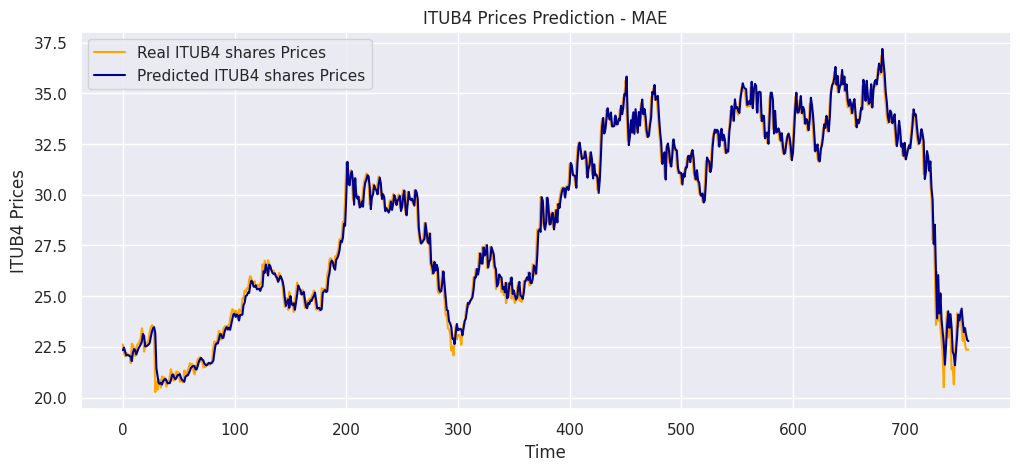

In [54]:
# Visualising the results
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test_set[timesteps:len(y_test)].astype(float), color = 'orange', label = 'Real ITUB4 shares Prices')
plt.plot(y_test[0:len(y_test) - timesteps].astype(float), color = 'darkblue', label = 'Predicted ITUB4 shares Prices')

plt.title('ITUB4 Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('ITUB4 Prices')
plt.legend()
plt.show()

In [55]:
predictions_series = pd.DataFrame(y_test[0:len(y_test) - timesteps].astype(float), columns=['pred'])
test_series = pd.DataFrame(test_set[timesteps:len(y_test)].astype(float),columns=['values'])

In [56]:
LSTM_Model_perf = forecast_accuracy(predictions_series['pred'], test_series['values'])

# Comparison Regressor models

In [57]:
print(" Linear Model RMSE: ",Linear_model_perf['rmse'], "\n",
      "Ridge Model RMSE: ",Ridge_model_perf['rmse'],"\n",
      "SARIMAX Model RMSE: ",SARIMAX_Model_perf['rmse'],"\n",
      "LSTM Model RMSE: ",LSTM_Model_perf['rmse'])

 Linear Model RMSE:  0.47313295029712965 
 Ridge Model RMSE:  0.4753148321559118 
 SARIMAX Model RMSE:  0.5405665003370218 
 LSTM Model RMSE:  0.5634368635894744


In [58]:
print(" Linear Model r_Squared: ",Linear_model_perf['r_squared'],"\n",
      "Ridge Model r_Squared: ",Ridge_model_perf['r_squared'],"\n",
      "SARIMAX Model r_Squared: ",SARIMAX_Model_perf['r_squared'],"\n",
      "LSTM Model r_Squared: ",LSTM_Model_perf['r_squared'])

 Linear Model r_Squared:  0.9889313678179593 
 Ridge Model r_Squared:  0.9888133385083395 
 SARIMAX Model r_Squared:  0.9889664366736943 
 LSTM Model r_Squared:  0.9844329449537034


The best regression model for our goal is the Linear Model. Fortunately or unfortunately, due it will required to be implemented using Pyspark in the next steps and it's very simple to do. The main goal is hit the nail on the head the Close value, thus Linear Model has the smallest RMSE. Of course, maybe if we spend more time to tunning the LSTM we could getting a best model, but as the purpose is learning and how everything fits together we will process with the simple linear model.